<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

---

In [2]:
import PyKEP as pk

In [3]:
import numpy as np

In [4]:
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 8

In [5]:
from gtoc5 import *
from gtoc5.multiobjective import *
from gtoc5.phasing import *

In [6]:
from paco import *

In [7]:
from paco_traj import *
from experiments import *
from experiments__paco import *

---

Let's take a look at our Python environment

In [8]:
%load_ext watermark
%watermark -v -m -p PyKEP,numpy,scipy,tqdm,pandas,matplotlib,seaborn
# https://github.com/rasbt/watermark

CPython 3.5.3
IPython 5.3.0

PyKEP {'bugfix': 9, 'major': 1, 'minor': 3}
numpy 1.12.1
scipy 0.19.0
tqdm 4.11.2
pandas 0.19.2
matplotlib 2.0.0
seaborn 0.7.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


---

# Solving a TSPLIB problem with P-ACO

Let's download from the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/) the symmetric TSP problem instance `eil101` (101 cities, total distance in best known solution: 629).

In [9]:
from urllib.request import urlretrieve
import gzip

In [10]:
urlretrieve('http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/eil101.tsp.gz', filename='eil101.tsp.gz');

Load each city's (x, y) coordinates

In [11]:
with gzip.open('eil101.tsp.gz') as f:
    xy_locs = np.loadtxt(f, skiprows=6, usecols=(1,2), comments='EOF', dtype=np.int)
nr_cities = len(xy_locs)
xy_locs[:5]

array([[41, 49],
       [35, 17],
       [55, 45],
       [55, 20],
       [15, 30]])

Calculate distances matrix

In [12]:
distances = np.zeros((nr_cities, nr_cities))
for a in range(nr_cities):
    for b in range(a, nr_cities):
        distances[a,b] = distances[b,a] = np.linalg.norm(xy_locs[a] - xy_locs[b])

distances[:4, :4]

array([[  0.        ,  32.55764119,  14.56021978,  32.20248438],
       [ 32.55764119,   0.        ,  34.40930107,  20.22374842],
       [ 14.56021978,  34.40930107,   0.        ,  25.        ],
       [ 32.20248438,  20.22374842,  25.        ,   0.        ]])

Instantiate the TSP "path handler" with this distances matrix

In [13]:
path_handler = tsp_path(distances)

Instantiate P-ACO, using the default parameters

In [14]:
rng, seed = initialize_rng(seed=None); print('Seed:', seed)
aco = paco(path_handler.nr_nodes, path_handler, random_state=rng)

Seed: 1972930898


Solve it, using a low number of generations

In [15]:
%time (quality, best) = aco.solve(nr_generations=100, reinitialize=True)
quality

Wall time: 6.97 s


651.4793842092497

Let's see what we found

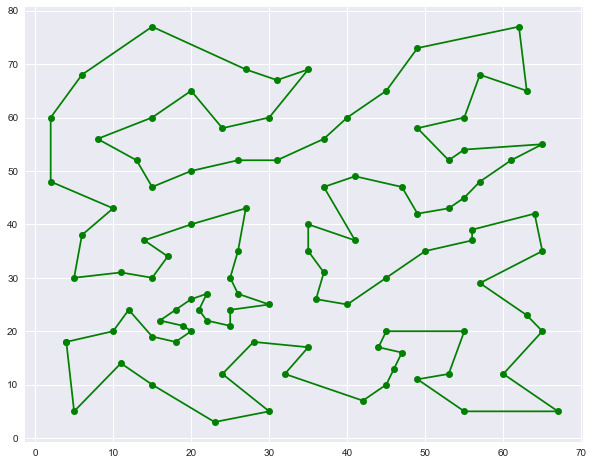

In [16]:
ax = plt.gca()
xy = np.vstack([xy_locs[best], xy_locs[best][0]]) # to connect back to the start
line, = ax.plot(xy[:,0], xy[:,1], 'go-')

# Finding a GTOC5 trajectory of score 17 with Beam Search

In [17]:
gtoc_ph = init__path_handler(multiobj_evals=True)

In [18]:
# configuring Beam P-ACO to behave as a deterministic multi-objective Beam Search
_args = {
    'beam_width': 20,
    'branch_factor': 250,
    'alpha': 0.0,        # 0.0: no pheromones used
    'beta': 1.0,
    'prob_greedy': 1.0,  # 1.0: deterministic, greedy branching decisions
    }

In [19]:
bpaco = beam_paco_pareto(nr_nodes=len(asteroids), path_handler=gtoc_ph, random_state=None, **_args)

In [20]:
# start the search
# given we're running the algoritm in deterministic mode, we execute it for a single generation
%time best_pf = bpaco.solve(nr_generations=1)

Wall time: 2min 10s


In [21]:
# being this a `_pareto` class, .best returns a Pareto front
# pick the first solution from the Pareto front
best_eval, best = best_pf[0]

In [22]:
# Evaluation of the best found solution
# (score, mass consumed, time of flight)
best_eval

(17.0, 3496.8299418637093, 14.824982263414686)

In [23]:
# sequence of asteroids visited (0 is the Earth)
print(seq(best, incl_flyby=False))

[0, 1712, 4893, 2579, 6979, 5469, 6740, 2445, 6301, 5174, 5884, 4165, 4028, 6240, 3988, 1779, 6813, 3243]


In [24]:
# mission data structure, up to the full scoring of the first two asteroids
best[:5]

[(0, 4000.0, 59127.205255048466, 0.0, 0.0),
 (1712,
  3872.530999146394,
  59181.08381655966,
  53.87856151119195,
  650.4716282561097),
 (1712,
  3746.481928641157,
  59325.360311294986,
  144.27649473533114,
  965.6854249492379),
 (4893,
  3602.066962005158,
  59582.911331703152,
  257.55102040816325,
  831.5807789590044),
 (4893,
  3484.7515275785117,
  59717.111314916867,
  134.19998321371767,
  965.6854249492379)]